In [2]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle
import gc
import re

import numpy as np
import pandas as pd

from importlib import reload

In [4]:
import seaborn as sns

In [5]:
import tensorflow as tf
tf.__version__

'1.13.1'

## Load the data

In [12]:
main_dir = '/Users/Natallia/Documents/R/W210_capstone/Project'
data_path = "/Users/Natallia/Documents/R/W210_capstone/Project/personalities_FINAL.csv"
df = pd.read_csv(data_path)
df.head()

,Personality,username,user_id,tweets,followers_count,image
0,enfj,pr3achlikeagirl,2.310891e+09,"['God is on the move!', 'Stop telling God what...",67,http://pbs.twimg.com/profile_images/1090079036...
1,enfj,ChurchTherapist,8.606921e+08,['@user It describes anxious attachment as opp...,1841,http://pbs.twimg.com/profile_images/1033441323...
2,enfj,camperry21,2.653982e+07,"[""@user @user He ain't winning with the Clippe...",1240,http://pbs.twimg.com/profile_images/1078547897...
3,enfj,galaxiaskykloz,2.268542e+09,"['does anyone remember poopreport dot com', '@...",2227,http://pbs.twimg.com/profile_images/1001856767...
4,enfj,sarahyoung_esq,1.090463e+18,"['MeatPotatoesNBeans ', 'THE LITTLE BLEP TONGU...",76,http://pbs.twimg.com/profile_images/1090465009...


In [13]:
df.shape

(175, 6)

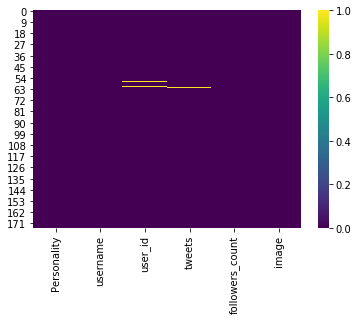

In [14]:
sns.heatmap(df.isna(),cmap = 'viridis')

In [15]:
#df.iloc[0,3]

# Data checking, cleaning

In [16]:
len(df)

175

In [17]:
# Check that all personality types are coming through correctly
personality_types = df.Personality.unique()
print(personality_types)

['enfj' 'enfp' 'entj' 'entp' 'infj' 'infp' 'intj' 'intp' 'isfp' 'istj'
 'istp' 'estj' 'isfj']


In [18]:
len(personality_types)

13

### We are missing 3 personality types: "esfj", "esfp", "estp".

In [19]:
len(df.username.unique())

149

In [20]:
len(df.user_id.unique())

148

In [21]:
duplicate_user_ids = df.duplicated(subset="user_id")
duplicate_usernames = df.duplicated(subset="username")

In [22]:
duplicate_user_ids = (duplicate_user_ids[duplicate_user_ids==True])
duplicate_usernames = (duplicate_usernames[duplicate_usernames==True])

In [23]:
len(duplicate_user_ids)

27

In [24]:
len(duplicate_usernames)

26

In [25]:
duplicate_user_ids

22     True
50     True
51     True
61     True
73     True
74     True
79     True
92     True
93     True
94     True
98     True
99     True
104    True
108    True
112    True
116    True
120    True
125    True
133    True
136    True
149    True
153    True
159    True
165    True
166    True
167    True
172    True
dtype: bool

In [26]:
duplicate_usernames

22     True
50     True
51     True
73     True
74     True
79     True
92     True
93     True
94     True
98     True
99     True
104    True
108    True
112    True
116    True
120    True
125    True
133    True
136    True
149    True
153    True
159    True
165    True
166    True
167    True
172    True
dtype: bool

In [27]:
#example of repeat usernames
df.iloc[50,2]

8.721172740769505e+17

In [28]:
user_50 = df[df.user_id == 8.721172740769505e+17]
print(user_50)

    Personality username       user_id  \
45         intj  TIL_ayg  8.721173e+17   
50         intj  TIL_ayg  8.721173e+17   
51         intj  TIL_ayg  8.721173e+17   
108        intj  TIL_ayg  8.721173e+17   

                                                tweets  followers_count  \
45   ['does anyone remember poopreport dot com', '@...             1816   
50   ['@user Oh no!  Are you ok?', '@user Wow!  Wha...             1816   
51   ['@user Good that you shared this online. Very...             1816   
108  ['', '', "Woke up and realized am okay. Okay t...             1807   

                                                 image  
45   http://pbs.twimg.com/profile_images/1065646698...  
50   http://pbs.twimg.com/profile_images/1065646698...  
51   http://pbs.twimg.com/profile_images/1065646698...  
108  http://pbs.twimg.com/profile_images/1065646698...  


### 26 users are repeated in the dataset

In [29]:
# Remove repeated users in dataframe

df = df.drop_duplicates(subset="username", keep="last")

In [30]:
len(df)

149

## Converting Tweets to List

In [31]:
df.head()

,Personality,username,user_id,tweets,followers_count,image
2,enfj,camperry21,2.653982e+07,"[""@user @user He ain't winning with the Clippe...",1240,http://pbs.twimg.com/profile_images/1078547897...
3,enfj,galaxiaskykloz,2.268542e+09,"['does anyone remember poopreport dot com', '@...",2227,http://pbs.twimg.com/profile_images/1001856767...
4,enfj,sarahyoung_esq,1.090463e+18,"['MeatPotatoesNBeans ', 'THE LITTLE BLEP TONGU...",76,http://pbs.twimg.com/profile_images/1090465009...
5,enfj,filmandtheatre,3.686383e+08,['oh my god she is adorable i love her so much...,6031,http://pbs.twimg.com/profile_images/1137455550...
6,enfj,MeghanLeVota,1.016060e+18,['@user I’m an ENFJ 1) individualization 2) fu...,1038,http://pbs.twimg.com/profile_images/1133759007...


In [32]:
# Checking for exceptions
non_string_tweets = []
for row in range (len(df)):
    if type(df.iloc[row, 3]) != str:
        non_string_tweets.append(row)
        print(row)
    

48


In [33]:
df.iloc[48,]

Personality                                                     intp
username                                               Juliamagdazrc
user_id                                                  3.43289e+09
tweets                                                           NaN
followers_count                                                   49
image              http://pbs.twimg.com/profile_images/1125699825...
Name: 62, dtype: object

In [34]:
len(non_string_tweets)

1

In [35]:
# Fixing exception; this isn't ideal
#df.iloc[48, 3] = "No Tweets"

In [36]:
tweet_dict = {}

for row in range (len(df)):
    username = df.iloc[row, 1]
    personality = df.iloc[row, 0]
    user_id = df.iloc[row, 2]
    followers_count = df.iloc[row, 4]
    tweets_str = df.iloc[row, 3]
    try:
        tweets = eval(tweets_str)
    except:
        tweets = tweets_str
    
    tweet_dict[username] = [user_id, personality, followers_count, tweets]

In [37]:
df_new = pd.DataFrame.from_dict(data = tweet_dict, orient='index', columns=['user_id', 'personality', 'follower_count', 'tweets'])

In [38]:
df_new.head()

,user_id,personality,follower_count,tweets
camperry21,2.653982e+07,enfj,1240,[@user @user He ain't winning with the Clipper...
galaxiaskykloz,2.268542e+09,enfj,2227,"[does anyone remember poopreport dot com, @use..."
sarahyoung_esq,1.090463e+18,enfj,76,"[MeatPotatoesNBeans , THE LITTLE BLEP TONGUE😭 ..."
filmandtheatre,3.686383e+08,enfj,6031,[oh my god she is adorable i love her so much ...
MeghanLeVota,1.016060e+18,enfj,1038,[@user I’m an ENFJ 1) individualization 2) fut...


In [39]:
df_new.shape

(149, 4)

In [40]:
df_new.shape

(149, 4)

In [261]:
#df_new.iloc[3,3]

### Remove row with NaN

In [45]:
df_new_n = df_new[df_new.index != "Juliamagdazrc"]
df_new_n.shape

(148, 4)

In [46]:
df_new_n.iloc[[48]]

,user_id,personality,follower_count,tweets
Wanderingc0rpse,1.080971e+18,intp,74,"[@user Mozart, Always be Lilith, never Eve., ,..."


In [47]:
df_l = df_new_n.tweets.tolist()
kk = df_l[9]
kk[0]
len(df_l)


148

In [50]:
#df_l[0]

In [51]:
len(df_l[0])

2886

In [347]:
numb = []
for i in range(len(df_l)):
    if type(df_l[i])!=float:
        numb.append(len(df_l[i]))
    else:
        print(i)
len(numb)
import matplotlib.pyplot as plt


In [349]:
print(df_new_n.iloc[[48]])

                      user_id personality  follower_count  \
Wanderingc0rpse  1.080971e+18        intp              74   

                                                            tweets  
Wanderingc0rpse  [@user Mozart, Always be Lilith, never Eve., ,...  


In [350]:
len(numb)

148

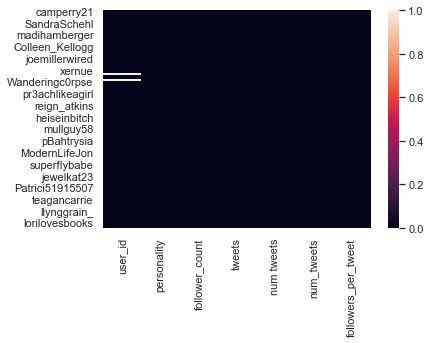

In [373]:
sns.heatmap(df_new_n.isna())

In [377]:
#df_new_n.head

In [352]:
df_new_n['num_tweets'] = numb
df_new_n.head()

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,user_id,personality,follower_count,tweets,num tweets,num_tweets
camperry21,2.653982e+07,enfj,1240,[@user @user He ain't winning with the Clipper...,2886,2886
galaxiaskykloz,2.268542e+09,enfj,2227,"[does anyone remember poopreport dot com, @use...",2271,2271
sarahyoung_esq,1.090463e+18,enfj,76,"[MeatPotatoesNBeans , THE LITTLE BLEP TONGUE😭 ...",758,758
filmandtheatre,3.686383e+08,enfj,6031,[oh my god she is adorable i love her so much ...,2407,2407
MeghanLeVota,1.016060e+18,enfj,1038,[@user I’m an ENFJ 1) individualization 2) fut...,2504,2504


In [159]:
#df_new.iloc[0,3]

In [141]:
import seaborn as sns

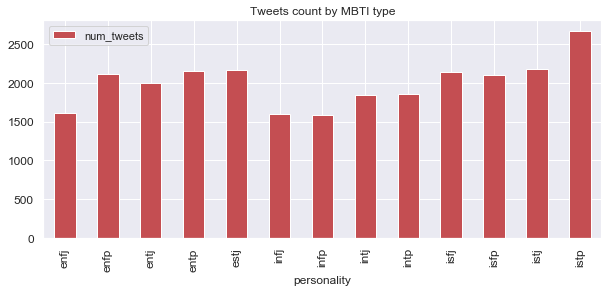

In [355]:
sns.set()
df_new_n.groupby("personality")['num_tweets'].mean().plot(kind='bar',\
                legend=True, figsize = (10,4),color = 'r', fontsize = 12, title = 'Tweets count by MBTI type')


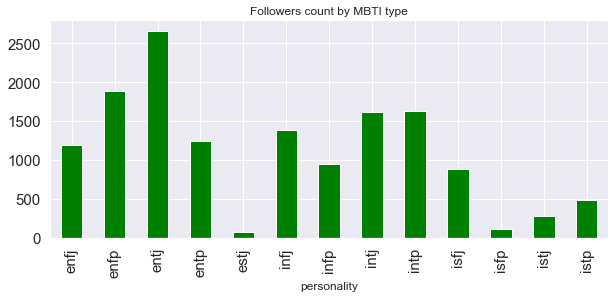

In [356]:
df_new_n.groupby("personality")['follower_count'].mean().plot(kind='bar',\
            figsize = (10,4),color = 'green', fontsize = 15, title = 'Followers count by MBTI type')

In [362]:
df_new_n.columns

Index(['user_id', 'personality', 'follower_count', 'tweets', 'num tweets',
       'num_tweets'],
      dtype='object')

In [370]:
df_new_n['followers_per_tweet'] = df_new_n.apply(lambda row: row.follower_count/row.num_tweets, axis=1)



//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [371]:
df_new_n.head()

,user_id,personality,follower_count,tweets,num tweets,num_tweets,followers_per_tweet
camperry21,2.653982e+07,enfj,1240,[@user @user He ain't winning with the Clipper...,2886,2886,0.429660
galaxiaskykloz,2.268542e+09,enfj,2227,"[does anyone remember poopreport dot com, @use...",2271,2271,0.980625
sarahyoung_esq,1.090463e+18,enfj,76,"[MeatPotatoesNBeans , THE LITTLE BLEP TONGUE😭 ...",758,758,0.100264
filmandtheatre,3.686383e+08,enfj,6031,[oh my god she is adorable i love her so much ...,2407,2407,2.505609
MeghanLeVota,1.016060e+18,enfj,1038,[@user I’m an ENFJ 1) individualization 2) fut...,2504,2504,0.414537


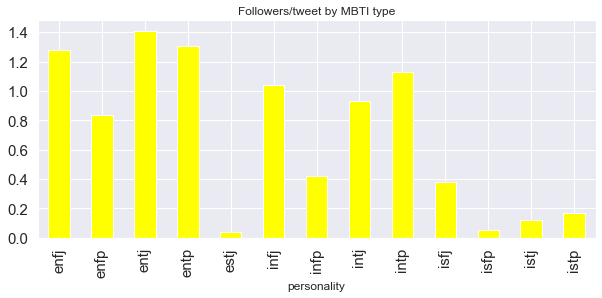

In [372]:
df_new_n.groupby("personality")['followers_per_tweet'].mean().plot(kind='bar',\
            figsize = (10,4),color = 'yellow', fontsize = 15, title = 'Followers/tweet by MBTI type')

### working with iloc in pandas
https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/

### how to check if DF has NA"
https://chartio.com/resources/tutorials/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe/

### filtering DF by name of column
https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/

### User's engagement in social media

In [378]:
# Module imports 
import tweepy
import time
import pandas as pd
import numpy as np
import json
import time
from random import randint, random
from googlesearch import search as gsearch
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [386]:
import json
import twitter

source:
    https://towardsdatascience.com/use-google-and-tweepy-to-build-a-dataset-of-twitter-users-cbfd556493a9

In [379]:
with open('twitter_credentials.json') as cred_data:
    info = json.load(cred_data)
    api_key = info['CONSUMER_KEY']
    secret_key = info['CONSUMER_SECRET']
    access_token = info['ACCESS_KEY']
    secret_token = info['ACCESS_SECRET']

In [382]:

def authenticate(api_key, secret_key, access_token, secret_token):

    auth = tweepy.OAuthHandler(api_key, secret_key)
    auth.set_access_token(access_token, secret_token)
    api = tweepy.API(auth, 
                     wait_on_rate_limit=True, 
                     wait_on_rate_limit_notify=True)
  
    return api


api = authenticate(api_key, secret_key, access_token, secret_token)

In [387]:
appi = twitter.Api(consumer_key='MGZq7elPgM7ebbiMMfehQpws3',
                      consumer_secret='8iCUvtegMrpwZhJyVdAkTfsQ10F8Ev6eUzEY8rHGZcOcnQsoAZ',
                      access_token_key='850564782310608896-eKZe7kL5H3pX4H6v8pDmGS4nM9SjEIw',
                      access_token_secret='sFokhSX1DiPvJleKNUWMJHeRf48nXAlQzwscf1QW8Gnxu')


#### Check if Twitter API is working

In [390]:

appi = twitter.Api(api_key, secret_key, access_token, secret_token)



In [401]:
print('my twitter info & tweete:','\n',appi.VerifyCredentials())

my twitter info & tweete: 
 {"created_at": "Sat Apr 08 04:23:41 +0000 2017", "default_profile": true, "default_profile_image": true, "favourites_count": 6, "followers_count": 5, "friends_count": 94, "id": 850564782310608896, "id_str": "850564782310608896", "name": "Natallia", "profile_background_color": "F5F8FA", "profile_image_url": "http://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png", "profile_image_url_https": "https://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png", "profile_link_color": "1DA1F2", "profile_sidebar_border_color": "C0DEED", "profile_sidebar_fill_color": "DDEEF6", "profile_text_color": "333333", "profile_use_background_image": true, "screen_name": "natallia112202", "status": {"created_at": "Mon Jun 24 05:13:15 +0000 2019", "id": 1143024265526038528, "id_str": "1143024265526038528", "in_reply_to_screen_name": "AOC", "in_reply_to_status_id": 1134591497951764481, "in_reply_to_user_id": 138203134, "lang": "en", "source": 

In [405]:
# Twitter API credentials

with open('twitter_credentials.json') as cred_data:
    info = json.load(cred_data)
    consumer_key = info['CONSUMER_KEY']
    consumer_secret = info['CONSUMER_SECRET']
    access_key = info['ACCESS_KEY']
    access_secret = info['ACCESS_SECRET']

# Create the api endpoint

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

# Mention the maximum number of tweets that you want to be extracted.

maximum_number_of_tweets_to_be_extracted = \
int(input('Enter the number of tweets that you want to extract- '))

# Mention the hashtag that you want to look out for

hashtag = input('Enter the hashtag you want to scrape- ')

for tweet in tweepy.Cursor(api.search, q='#' + hashtag,rpp=100,lang="en",tweet_mode='extended').items(maximum_number_of_tweets_to_be_extracted):
    
    with open('tweets_with_hashtag_' + hashtag + '.txt', 'a') as \
    the_file:
        the_file.write(str(tweet.text) + '\n')

    print ('Extracted ' + str(maximum_number_of_tweets_to_be_extracted) \
    + ' tweets with hashtag #' + hashtag)
    

Enter the number of tweets that you want to extract- 600
Enter the hashtag you want to scrape- MBTI


AttributeError: 'Status' object has no attribute 'text'

### Catch all the users on the hashtag MBTI (most probable plece to find users!)

In [419]:
# Twitter API credentials

with open('twitter_credentials.json') as cred_data:
    info = json.load(cred_data)
    consumer_key = info['CONSUMER_KEY']
    consumer_secret = info['CONSUMER_SECRET']
    access_key = info['ACCESS_KEY']
    access_secret = info['ACCESS_SECRET']

# Create the api endpoint

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
api = tweepy.API(auth)

# Mention the maximum number of tweets that you want to be extracted.

maximum_number_of_tweets_to_be_extracted = \
int(input('Enter the number of tweets that you want to extract- '))

# Mention the hashtag that you want to look out for

hashtag = input('Enter the hashtag you want to scrape- ')

for tweet in tweepy.Cursor(api.search, q='#' + hashtag,\
    rpp=100,lang="en").items(maximum_number_of_tweets_to_be_extracted):
        with open('tweets_with_hashtag_' + hashtag + '.txt', 'a') as \
        the_file:
            the_file.write(str(tweet.text) + '\n')

print ('Extracted ' + str(maximum_number_of_tweets_to_be_extracted) \
+ ' tweets with hashtag #' + hashtag)

Enter the number of tweets that you want to extract- 300
Enter the hashtag you want to scrape- MBTI
Extracted 300 tweets with hashtag #MBTI


In [534]:
mbtifile = open('tweets_with_hashtag_MBTI.txt','r')

#mbtifile.readline()

In [597]:
with open('tweets_with_hashtag_MBTI.txt') as f:
    data = f.readlines()
    users = []
    num_lines = 0
    num_mbti1 = 0
    
    for line in data:
        num_lines += 1
        if 'MBTI' in line:
            num_mbti1+=1
            
        wordlist = line.split()
        
        #print(wordlist)
        
        users.append([word[1:-1] for word in wordlist if word[0]=='@'])
    all_users = [u[0] for u in users if len(u)>0]
            
    #all_lines.append(words)   
    
    #users = [w for w in all_lines if w[0]=='@']
MBTI_users = list(set(all_users))
print("unique users collected", len(set(all_users)))
print('lines in the file',num_lines)
print('lines where MBTI is mentioned',num_mbti1)
print('the list of users',MBTI_users)

unique users collected 58
lines in the file 486
lines where MBTI is mentioned 118
the list of users ["realDonaldTrump'", 'SANDAPT', 'YouTub', 'DesignCULT_002', 'JohnHackston', '16Personalitie', 'FIRESTARTERS101', 'BarackObam', 'mbti_insights', 'elyssarahilly_', 'AusAPT', 'introvert360', 'theinfjwoman', 'LoreAdept', 'mbtifacts1', 'JohannesPinina', 'INTParent76', 'cuppaJasmine', 'FlowState9', 'erikthor_', 'StellaSanLF', 'SANDAP', 'AJThurston', 'allifenwick_', 'theRealENTJ', 'JZType', 'theINTJnovelis', 'Discovering_Her', 'alonzovibez_23', 'ChrisRCason', 'themyersbrigg', 'lakedirect', 'CateHawekotte', 'atopcareer', 'atopcaree', 'SatoshiDoodles', 'StellaYeahilike', 'zdon89', 'AusAP', 'ENFJ_Support', 'inkandstars', 'WarmestRobot', 'xQ', 'all_of_MBTI', 'Grumpyturtle0', 'we', 'ELFT_OD', 'thereelanna', 'match_type', 'Shon_Doe', 'mbti_insight', 'PsychometricsCA', 'commcapers', 'Yeahilike', 'theINTJnovelist', 'GodYaylor', 'YAI019', 'blueskyperfor']


#### link
https://stackoverflow.com/questions/22469713/managing-tweepy-api-search

In [420]:
query = 'I am ESFJ'
max_tweets = 1000
searched_tweets = []
last_id = -1
while len(searched_tweets) < max_tweets:
    count = max_tweets - len(searched_tweets)
    try:
        new_tweets = api.search(q=query, count=count, max_id=str(last_id - 1))
        if not new_tweets:
            break
        searched_tweets.extend(new_tweets)
        last_id = new_tweets[-1].id
    except tweepy.TweepError as e:
        # depending on TweepError.code, one may want to retry or wait
        # to keep things simple, we will give up on an error
        break


In [457]:
type(searched_tweets[1])

tweepy.models.Status

In [467]:
len(searched_tweets)

11

### about tweepy.models.Status object

https://stackoverflow.com/questions/27900451/convert-tweepy-status-object-into-json#comment68376331_27901076

#### COnvert tweepy.models.Status object into regular dictionary (json)

In [465]:
full_text = []
for i in range(len(searched_tweets)):
    
    status = searched_tweets[i]
    json_str = json.dumps(status._json)
    full_text.append(json_str)

In [466]:
len(full_text)

11

In [593]:
## Big dictionary (0ne of 11)
full_text[1]

'{"created_at": "Tue Jul 02 18:17:21 +0000 2019", "id": 1146120690816442370, "id_str": "1146120690816442370", "text": "I am ESFJ and I got sailor Jupiter!\\nHere\\u2019s the Myers-Briggs test: https://t.co/63lzFus4ZX", "truncated": false, "entities": {"hashtags": [], "symbols": [], "user_mentions": [], "urls": [{"url": "https://t.co/63lzFus4ZX", "expanded_url": "http://16personalities.com", "display_url": "16personalities.com", "indices": [66, 89]}]}, "metadata": {"iso_language_code": "en", "result_type": "recent"}, "source": "<a href=\\"http://twitter.com/download/iphone\\" rel=\\"nofollow\\">Twitter for iPhone</a>", "in_reply_to_status_id": 1146113826577948672, "in_reply_to_status_id_str": "1146113826577948672", "in_reply_to_user_id": 1023392516996034560, "in_reply_to_user_id_str": "1023392516996034560", "in_reply_to_screen_name": "KagurasDream", "user": {"id": 1023392516996034560, "id_str": "1023392516996034560", "name": "Vix \\u2728 \\ud83c\\udff3\\ufe0f\\u200d\\ud83c\\udf08", "scr

In [470]:
with open('all_ESFJ_2.txt', 'w') as f:
    for item in full_text:
        f.write("%s\n" % item)

In [471]:
tweets_data_path = 'all_ESFJ_2.txt'

In [472]:
tweets_data = []
tweets_file = open(tweets_data_path, "r")
for line in tweets_file:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        print('!!!!')
        continue

In [474]:
len(tweets_data)

11

In [483]:
type(tweets_data[0])

dict

In [501]:
tweets_data[1]

{'created_at': 'Tue Jul 02 18:17:21 +0000 2019',
 'id': 1146120690816442370,
 'id_str': '1146120690816442370',
 'text': 'I am ESFJ and I got sailor Jupiter!\nHere’s the Myers-Briggs test: https://t.co/63lzFus4ZX',
 'truncated': False,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [{'url': 'https://t.co/63lzFus4ZX',
    'expanded_url': 'http://16personalities.com',
    'display_url': '16personalities.com',
    'indices': [66, 89]}]},
 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'in_reply_to_status_id': 1146113826577948672,
 'in_reply_to_status_id_str': '1146113826577948672',
 'in_reply_to_user_id': 1023392516996034560,
 'in_reply_to_user_id_str': '1023392516996034560',
 'in_reply_to_screen_name': 'KagurasDream',
 'user': {'id': 1023392516996034560,
  'id_str': '1023392516996034560',
  'name': 'Vix ✨ 🏳️\u200d🌈',
  'screen_name': 'Kagura

In [507]:
tweets_data[1]['user']['followers_count']

1895

In [509]:
len(tweets_data)

11

In [510]:
timestamp = []
tweet_text = []
username = []
image = []
followers_count = []
for i in range(len(tweets_data)):
    timestamp.append(tweets_data[i]['created_at'])
    
    tweet_text.append(tweets_data[i]['text'])
    username.append(tweets_data[i]['user']['screen_name'])
    image.append(tweets_data[i]['user']['profile_image_url'])
    followers_count.append(tweets_data[i]['user']['followers_count'])


In [513]:
df_ESFJ = pd.DataFrame(list(zip(timestamp,tweet_text,username,image,followers_count)),
              columns=['timestamp','tweet_text','username','image','followers_count'])

In [518]:
df_ESFJ.iloc[3,1]

'@cathyknightscot Now obsessively googling ESFJ. I have also learnt I am a type 2 personality... #notagoodthing'

In [512]:
df_ESFJ = pd.DataFrame()
df_ESFJ['timestamp']=timestamp
df_ESFJ['tweet_text']=tweet_text
df_ESFJ['username']=username
df_ESFJ['image']=image
df_ESFJ['ollowers_count']=followers_count

df_ESFJ

,timestamp,tweet_text,username,image,ollowers_count
0,Wed Jul 03 09:51:35 +0000 2019,S vs N at the summer cottage.\nENFP: How long ...,Sagotantenett,http://pbs.twimg.com/profile_images/6351313827...,18
1,Tue Jul 02 18:17:21 +0000 2019,I am ESFJ and I got sailor Jupiter!\nHere’s th...,KagurasDream,http://pbs.twimg.com/profile_images/1143893596...,1895
2,Tue Jul 02 01:25:48 +0000 2019,@MattWaters9 I am an ESFJ!,IrishHoneyDip,http://pbs.twimg.com/profile_images/1142952533...,1658
3,Sat Jun 29 21:01:09 +0000 2019,@cathyknightscot Now obsessively googling ESFJ...,amymeganbrown,http://pbs.twimg.com/profile_images/1143969577...,113
4,Sat Jun 29 16:40:48 +0000 2019,"In an alternative universe, I am ESFJ.\n\nImag...",JohannesPinina,http://pbs.twimg.com/profile_images/1067147954...,603
5,Sat Jun 29 04:21:20 +0000 2019,Personalities are fascinating to me. The more ...,CarissaRaye68,http://pbs.twimg.com/profile_images/1132827578...,37
6,Fri Jun 28 12:35:52 +0000 2019,so um she's an esfj...............for referenc...,swainashleyyyy,http://pbs.twimg.com/profile_images/1145358709...,222
7,Thu Jun 27 20:11:07 +0000 2019,@andreia_nichols @mworkwork Nice! I am ESFJ as...,hailleymari,http://pbs.twimg.com/profile_images/1118729261...,4942
8,Wed Jun 26 09:15:34 +0000 2019,"Last night i was reading description of INFP, ...",flowerlec,http://pbs.twimg.com/profile_images/1103321841...,168
9,Wed Jun 26 01:37:36 +0000 2019,"Based on this test I just took, it said I am a...",DaCapricorn,http://pbs.twimg.com/profile_images/6461292295...,814


In [586]:
import csv
import os,re,csv
p_type ='ESFJ'
timeframe = 'Jun_25_Jul_03'
fname = ('_'.join(p_type)+'_'+timeframe + '.csv')


In [591]:
fname = ('_'.join(p_type)+'_'+timeframe + '.csv')
df_ESFJ.to_csv(fname, index = None, header=True)


In [592]:
print(df_ESFJ[['tweet_text']])

                                           tweet_text
0   S vs N at the summer cottage.\nENFP: How long ...
1   I am ESFJ and I got sailor Jupiter!\nHere’s th...
2                          @MattWaters9 I am an ESFJ!
3   @cathyknightscot Now obsessively googling ESFJ...
4   In an alternative universe, I am ESFJ.\n\nImag...
5   Personalities are fascinating to me. The more ...
6   so um she's an esfj...............for referenc...
7   @andreia_nichols @mworkwork Nice! I am ESFJ as...
8   Last night i was reading description of INFP, ...
9   Based on this test I just took, it said I am a...
10  they gave me: straight as a pole\ni am: lil bi...


In [500]:
tweets_data[0]['user']['screen_name']

'Sagotantenett'

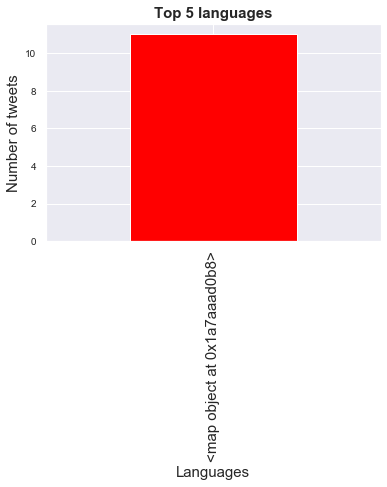

In [480]:
tweets_by_lang = tweets['lang'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Languages', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 languages', fontsize=15, fontweight='bold')
tweets_by_lang[:5].plot(ax=ax, kind='bar', color='red')

https://stackoverflow.com/questions/899103/writing-a-list-to-a-file-with-python

In [ ]:
Status(_api=<tweepy.api.API object at 0x1a7aa4ec18>, _json=

In [437]:
import pickle

with open('all_ESFJ', 'wb') as fp:
    pickle.dump(searched_tweets, fp)

In [438]:
with open('all_ESFJ_1.txt', 'w') as f:
    for item in searched_tweets:
        f.write("%s\n" % item)

In [454]:
tweets_data_path = 'all_ESFJ_1.txt'
tweets_data_path

'all_ESFJ_1.txt'

In [455]:


tweets_data = []
tweets_file = open(tweets_data_path, "r")
for line in tweets_file:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        print('!!!!')
        continue

!!!!
!!!!
!!!!
!!!!
!!!!
!!!!
!!!!
!!!!
!!!!
!!!!
!!!!


In [456]:
tweets_data

[]

In [441]:
ESFP_tweets = pd.DataFrame()

In [442]:
ESFP_tweets['screen_name'] = map(lambda tweet: tweet['screen_name'], tweets_data)
ESFP_tweets['text'] = map(lambda tweet: tweet['text'], tweets_data)
ESFP_tweets['lang'] = map(lambda tweet: tweet['lang'], tweets_data)
ESFP_tweets['country'] = map(lambda tweet: tweet['place']['country'] if tweet['place'] != None else None, tweets_data)

In [443]:
ESFP_tweets.head()

,screen_name,text,lang,country


In [436]:
import json
with open('all_ESFJ.txt', 'w') as f:
    f.write(json.dumps(searched_tweets))

TypeError: Object of type 'Status' is not JSON serializable

In [435]:
outtweets = []
for tweet in searched_tweets:
    ## added the language requirement
    if(len(tweet.text)>0) and tweet.lang == "en":
        outtweets.append([tweet.screen_name,tweet.id_str, tweet.created_at,tweet.text,tweet.followers_count,tweet.profile_image_url])
    else:
        outtweets.append([tweet.screen_name,tweet.id_str, tweet.created_at,'',tweet.followers_count,tweet.profile_image_url])

    #print("we are here")
#write the csv
    with open('%s.csv' % ESFJ, 'w', encoding='utf-8') as f:
            writer = csv.writer(f, delimiter = ',')
            writer.writerows(outtweets)


AttributeError: 'Status' object has no attribute 'screen_name'

In [423]:

userID = [i['user']["id"] for i in tweets]

#userGen = [i['user']["description"] for i in tweets]
userPhoto = [i['user']["profile_image_url"] for i in tweets]

created = [i["created_at"] for i in tweets]
#tweettext
#userID
len(userID)

AttributeError: 'Status' object has no attribute 'AsDict'

In [399]:
df_new_n.iloc[0, lambda df_new_n: [0,3]]

user_id                                          2.65398e+07
tweets     [@user @user He ain't winning with the Clipper...
Name: camperry21, dtype: object

In [ ]:
### Missing "esfj", "esfp", "estp"